In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
file_path = 'gdrive/My Drive/ColabNotebooks/Seahorse/' 
'''

In [1]:
import pandas as pd
import numpy as np
import scipy.signal
from sys import getsizeof
import matplotlib.pyplot as plt
import re 
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, clone_model
from keras.utils import np_utils
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
def normalize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - min(row))/(max(row) - min(row)) 
    return data

In [4]:
def read_data_files():
    data = pd.DataFrame()
    
    for filename in os.listdir('../data/buy/'):
        if filename.endswith(".txt"): 
            # symbol = filename.split("1")[0]
            tmp_df = pd.read_csv(os.path.join('../data/buy/', filename), delimiter= '\s+', header = None)
            tmp_df = tmp_df.astype(float)
            # tmp_df = pd.concat([pd.Series([symbol] * tmp_df.shape[0], name = 'symbol'), tmp_df], axis=1)
            tmp_df = tmp_df.iloc[20:,:]
            data = pd.concat([data, tmp_df])
    
    osc_names = ['osc' + str(i+1) for i in range(41)]
    prc_names = ['prc' + str(i+1) for i in range(41)]
    macd_names = ['macd' + str(i+1) for i in range(41)]
    data.columns = osc_names + prc_names + macd_names + ['rtn']
    
    osc_data = data.iloc[:, :41].reset_index(drop=True)
    osc_data = osc_data[osc_data.columns[::-1]]
    prc_data = data.iloc[:, 41:82].reset_index(drop=True)
    prc_data = prc_data[prc_data.columns[::-1]]
    prc_data = normalize_data(prc_data)
    macd_data = data.iloc[:, 82:123].reset_index(drop=True)
    macd_data = macd_data[macd_data.columns[::-1]]
    rtn = data['rtn'].reset_index(drop=True)
    label = pd.Series(map(lambda x: 1 if x>0 else 0, rtn), name = 'label')
    data = pd.concat([osc_data, prc_data, macd_data, rtn, label], axis=1)
    data = data.reset_index(drop=True)
    
    return data

In [5]:
def remove_duplicates(data):
    # target_names = list(data.columns)
    # del target_names[0]
    clean_data = data.drop_duplicates()
    clean_data= clean_data.reset_index(drop=True)
    return clean_data

In [6]:
def remove_extreme_values(data): 
    data = data[(data['osc1'] > -7) & (data['osc1'] < 7)] 
    data = data.reset_index(drop=True)
    return data

In [7]:
def remove_pos_values(data):
    data = data[data['osc1'] < 0]
    data = data.reset_index(drop=True)
    return data

In [10]:
class StockData():
    def __init__(self, data):

        pos_data = data[data['label'] == 1]
        neg_data = data[data['label'] == 0]
        
        sample_size = 10000
        pos_data = pos_data.sample(int(sample_size/2))
        neg_data = neg_data.sample(int(sample_size/2))
        data = pd.concat([pos_data, neg_data], axis = 0)
        data = data.reset_index(drop = True) 
        
        X = data.iloc[:, :124]
        y = data['label']
        
        X_train_valid_w_rtn, X_test_w_rtn, y_train_valid, y_test = train_test_split(X, y, test_size=0.25) 
        # train_valid set
        self.train_valid_rtn = X_train_valid_w_rtn['rtn']
        self.X_train_valid = X_train_valid_w_rtn.drop(['rtn'], axis = 1)
        self.y_train_valid = y_train_valid
        
        X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(X_train_valid_w_rtn, y_train_valid, test_size=0.25) 
        # training set 
        self.train_rtn = X_train_w_rtn['rtn'] 
        self.X_train = X_train_w_rtn.drop(['rtn'], axis = 1)
        self.y_train = y_train
        # validation set
        self.valid_rtn = X_valid_w_rtn['rtn']
        self.X_valid = X_valid_w_rtn.drop(['rtn'], axis = 1) 
        self.y_valid = y_valid
        # test set 
        self.test_rtn = X_test_w_rtn['rtn']
        self.X_test = X_test_w_rtn.drop(['rtn'], axis = 1)        
        self.y_test = y_test 

In [11]:
data = read_data_files()
data = remove_duplicates(data) 
data = remove_extreme_values(data)
# data = remove_pos_values(data)
stock_data = StockData(data)
print(stock_data.X_train.shape)
print(stock_data.X_valid.shape)
print(stock_data.X_test.shape)

(5625, 123)
(1875, 123)
(2500, 123)


In [16]:
def data_to_img(data):
    fig, axes = plt.subplots(3, 1, sharex = True)
    fig.set_figheight(3)
    fig.set_figwidth(2)
    fig.tight_layout(pad=0)
    for i in range(3):
        axes[i].plot(range(41), data[41*i:41*(i+1)], 'black')
    
    fig.canvas.draw()
    img_arr = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_arr = img_arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()  
    return img_arr

(216, 144, 3)

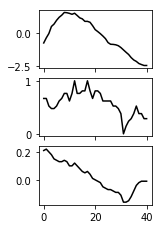

In [15]:
# test whether function 'data_to_img' works properly
img_arr = data_to_img(stock_data.X_train.iloc[999, :])
img_arr.shape

In [17]:
# initiate X_train_img
X_train_img = []
for i in range(stock_data.X_train.shape[0]):
  X_train_img.append(data_to_img(stock_data.X_train.iloc[i, :])) 
  if i%1000 == 0:
    print(i, end=' ')
print('\n')
X_train_img = np.array(X_train_img)
X_train_img.shape

0 1000 2000 3000 4000 5000 



(5625, 216, 144, 3)

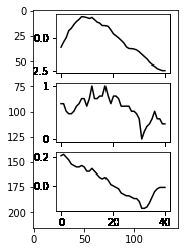

In [18]:
# check whether we get the correct X_train_img
plt.imshow(X_train_img[999,:,:,:])

In [20]:
y_train = to_categorical(stock_data.y_train)
y_train.shape

(5625, 2)

In [21]:
# initiate X_valid_img
X_valid_img = []
for i in range(stock_data.X_valid.shape[0]):
  X_valid_img.append(data_to_img(stock_data.X_valid.iloc[i, :123])) 
  if i%1000 == 0:
    print(i, end=' ')
print('\n')
X_valid_img = np.array(X_valid_img)
X_valid_img.shape

0 1000 



(1875, 216, 144, 3)

In [22]:
y_valid = to_categorical(stock_data.y_valid)
y_valid.shape

(1875, 2)

In [23]:
# initiate X_test_img
X_test_img = []
for i in range(stock_data.X_test.shape[0]):
  X_test_img.append(data_to_img(stock_data.X_test.iloc[i, :123])) 
  if i%1000 == 0:
    print(i, end=' ')
print('\n')
X_test_img = np.array(X_test_img)
X_test_img.shape

0 1000 2000 



(2500, 216, 144, 3)

In [25]:
y_test = to_categorical(stock_data.y_test)
y_test.shape

(2500, 2)

## try CNN model using 2D data (oscillator/price/macd plots)

In [26]:
model = Sequential()
model.add(Conv2D(32, (6, 6), input_shape=(216, 144,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_img, y_train, epochs=20, verbose=1, validation_data=(X_valid_img, y_valid))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 5625 samples, validate on 1875 samples
Epoch 1/20
5625/5625 [==============================] - 326s 58ms/step - loss: 8.0204 - acc: 0.5006 - val_loss: 8.2353 - val_acc: 0.4891
Epoch 2/20
5625/5625 [==============================] - 312s 56ms/step - loss: 7.8862 - acc: 0.5086 - val_loss: 8.2353 - val_acc: 0.4891
Epoch 3/20
5625/5625 [==============================] - 333s 59ms/step - loss: 7.8965 - acc: 0.5088 - val_loss: 8.2353 - val_acc: 0.4891
Epoch 4/20
5625/5625 [==============================] - 340s 60ms/step - loss: 7.9706 - acc: 0.5045 - val_loss: 8.2353 - val_acc: 0.4891
Epoch 5/20
5625/5625 [==============================] - 326s 58ms/step - loss: 7.9095 - acc: 0.5068 - val_loss: 8.2353 - val_acc: 0.4891
Epoch 6/20
5625/5625 [==========

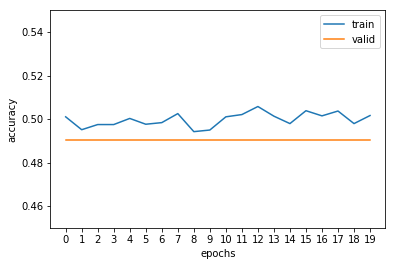

In [18]:
# results using training set and valid set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(0.45, 0.55)
plt.xticks(range(0, 20))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'valid']);

In [ ]:
pred = model.predict(X_valid_img)
print(classification_report(y_valid, pred))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_img, y_train, epochs=20, verbose=1, validation_data=(X_test_img, y_test))

In [ ]:
# results using training set and test set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(0.45, 0.55)
plt.xticks(range(0, 20))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test']);

In [22]:
pred = model.predict(X_test_img)
print(classification_report(y_test, pred))

In [28]:
data.head(10)

,osc41,osc40,osc39,osc38,osc37,osc36,osc35,osc34,osc33,osc32,...,macd8,macd7,macd6,macd5,macd4,macd3,macd2,macd1,rtn,label
0,-5.68,-7.41,-9.97,-12.28,-13.99,-14.43,-14.78,-14.55,-14.44,-14.65,...,0.06,0.04,0.03,0.07,0.10,0.11,0.14,0.14,-1.06,0
1,-12.28,-13.99,-14.43,-14.78,-14.55,-14.44,-14.65,-13.67,-12.92,-12.43,...,0.07,0.10,0.11,0.14,0.14,0.13,0.11,0.10,-0.53,0
2,-14.43,-14.78,-14.55,-14.44,-14.65,-13.67,-12.92,-12.43,-11.79,-11.16,...,0.11,0.14,0.14,0.13,0.11,0.10,0.08,0.08,-5.32,0
3,0.78,1.40,2.16,2.75,3.26,2.89,1.93,0.61,-0.67,-2.43,...,0.03,0.02,0.00,0.01,0.02,0.01,0.01,0.00,-0.56,0
4,2.16,2.75,3.26,2.89,1.93,0.61,-0.67,-2.43,-4.29,-6.33,...,0.00,0.01,0.02,0.01,0.01,0.00,-0.01,-0.01,-5.03,0
5,-9.77,-8.67,-6.30,-3.78,-1.30,1.23,3.64,5.83,8.27,9.46,...,-0.18,-0.17,-0.16,-0.14,-0.12,-0.14,-0.11,0.02,2.29,1
6,-1.08,-1.32,-1.29,-1.29,-1.01,-0.66,-0.92,-1.41,-2.24,-3.37,...,0.12,0.14,0.14,0.13,0.12,0.10,0.08,0.07,1.12,1
7,-3.98,-4.75,-5.65,-6.49,-7.06,-7.60,-7.75,-7.92,-8.14,-6.89,...,0.02,-0.00,0.01,0.02,0.02,0.02,0.01,0.04,-0.53,0
8,-6.49,-7.06,-7.60,-7.75,-7.92,-8.14,-6.89,-5.67,-4.42,-2.62,...,0.02,0.02,0.02,0.01,0.04,0.05,0.05,0.05,-8.06,0
9,3.41,3.66,3.70,3.82,3.52,3.18,3.08,2.93,2.80,2.59,...,-0.14,-0.15,-0.16,-0.18,-0.17,-0.14,-0.13,-0.06,0.00,0
